In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is NOT available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [3]:
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FDN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ]) for _ in range(N_LAYERS-1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


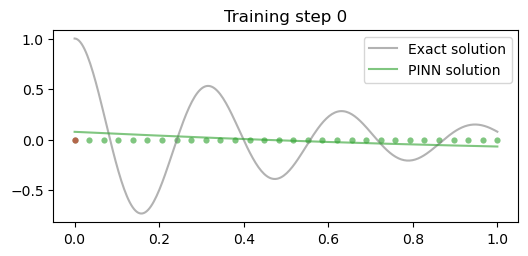

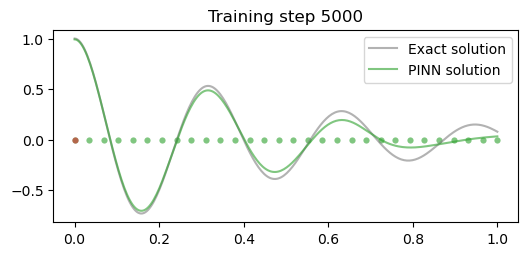

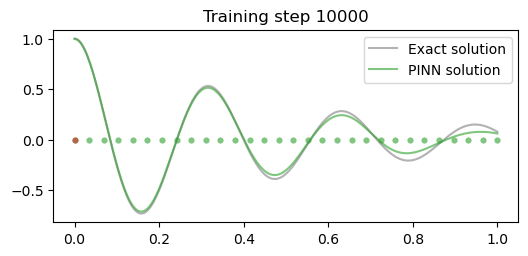

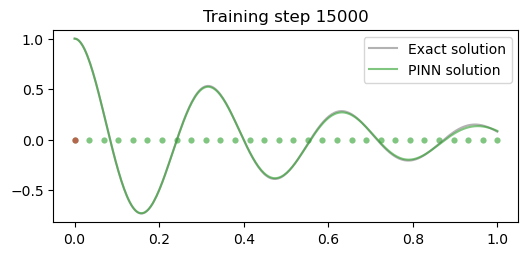

In [4]:
torch.manual_seed(123)

pinn = FDN(1,1,32,3)

t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(15001):
    optimizer.zero_grad()

    lambda_1, lambda_2 = 1e-1, 1e-4

    u = pinn(t_boundary)
    loss_1 = (torch.squeeze(u) - 1)**2

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss_2 = (torch.squeeze(dudt)-0)**2

    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss_3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    loss = loss_1 + lambda_1*loss_2 + lambda_2*loss_3
    loss.backward()
    optimizer.step()

    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(
            t_physics.detach()[:,0],
            torch.zeros_like(t_physics)[:,0],
            s=20,
            lw=0,
            color="tab:green",
            alpha=0.6
        )
        plt.scatter(
            t_boundary.detach()[:,0],
            torch.zeros_like(t_boundary)[:,0],
            s=20,
            lw=0,
            color="tab:red",
            alpha=0.6
        )
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:gray", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green", alpha=0.6)
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

Inverse

True value of mu: 4


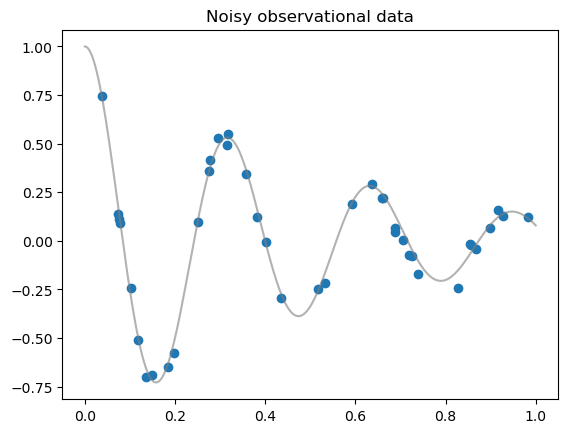

In [5]:
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1, 1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:gray", alpha=0.6)
plt.show()

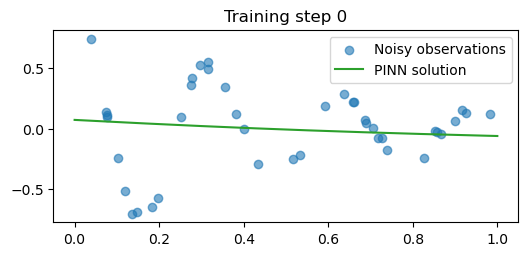

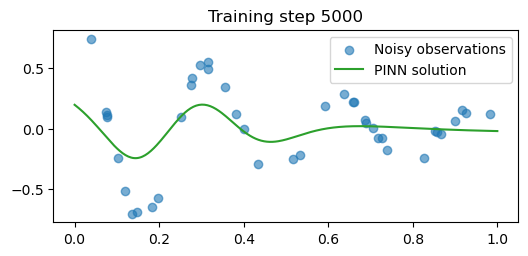

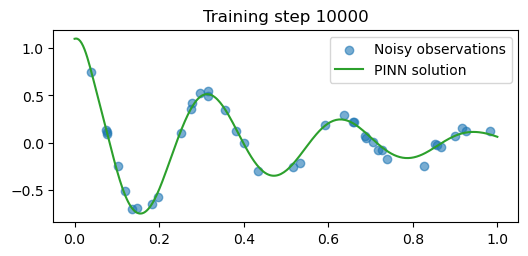

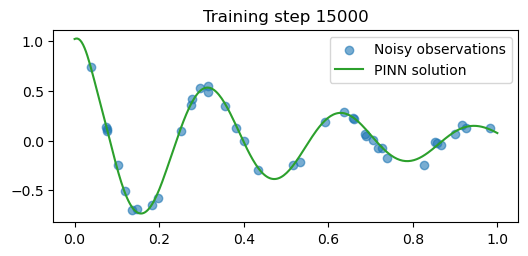

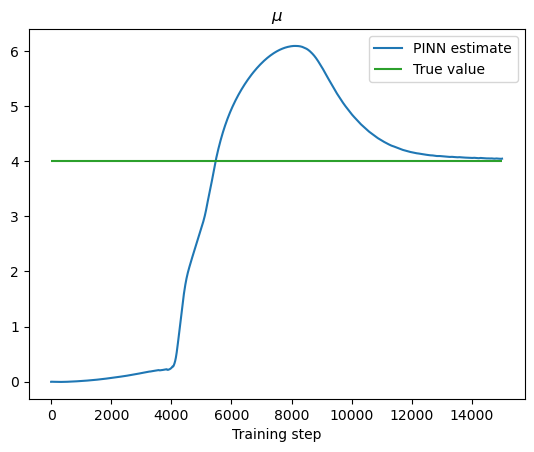

In [6]:
torch.manual_seed(123)

pinn = FDN(1,1,32,3)

t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

d, w0 = 2, 20
_, k = 2*k, w0**2

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []
optimizer = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)

for i in range(15001):
    optimizer.zero_grad()

    lambda_1 = 1e4

    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss_1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    u = pinn(t_obs)
    loss_2 = torch.mean((u - u_obs)**2)

    loss = loss_1 + lambda_1*loss_2
    loss.backward()
    optimizer.step()

    mus.append(mu.item())

    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(
            t_obs[:,0],
            u_obs[:,0],
            label="Noisy observations",
            alpha=0.6
        )
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()